## Collect Model Output Data and Generate Features

In [17]:
import os
import numpy as np
import pandas as pd

In [18]:
product_df = pd.read_csv('../../data/processed/product_data.csv')
# Remove floats
# product_df = product_df.loc[product_df['product_name'].apply(lambda x: isinstance(x, str)),:]
# product_df = product_df.loc[product_df['is_ordered_history'].apply(lambda x: isinstance(x, str)),:].reset_index(drop=True)
# product_df = product_df[["user_id", "product_id", "label"]] # usecols=['user_id', 'product_id', 'label']
product_df = pd.read_csv('../../data/processed/product_data.csv', usecols=['user_id', 'product_id', 'label'])


/storage/work/z/zbh5185/myenv/lib64/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.


In [19]:
# Check Data Shape
product_df.shape
# Check Label type
label_col = product_df['label']
label_set = set(label_col)
label_count = {i: sum(label_col == i) for i in label_set}
print(label_count)

{0: 115596, 1: 12147, -1: 331224}


In [20]:
products = pd.read_csv('../../data/raw/products.csv')
product_df = product_df.merge(products, how='left', on='product_id')

orders = pd.read_csv('../../data/raw/orders.csv')
orders = orders[orders['eval_set'].isin({'train', 'test'})]
product_df = product_df.merge(orders[['user_id', 'order_id']], how='left', on='user_id').reset_index(drop=True)
product_df['is_none'] = (product_df['product_id'] == 0).astype(int)

In [21]:
# product_df.head(12) # Check DataFrame

In [22]:
# nn feature representations
prefix = 'rnn_product'
h_df = pd.DataFrame(np.load('../rnn_product/predictions/final_states.npy')).add_prefix('{}_h'.format(prefix))
h_df['user_id'] = np.load('../rnn_product/predictions/user_ids.npy')
h_df['product_id'] = np.load('../rnn_product/predictions/product_ids.npy')
product_df = h_df.merge(product_df, how='left', on=['user_id', 'product_id']).reset_index(drop=True) # Feature Oriented Merging
product_df = product_df[product_df["label"].notna()] # remove NA

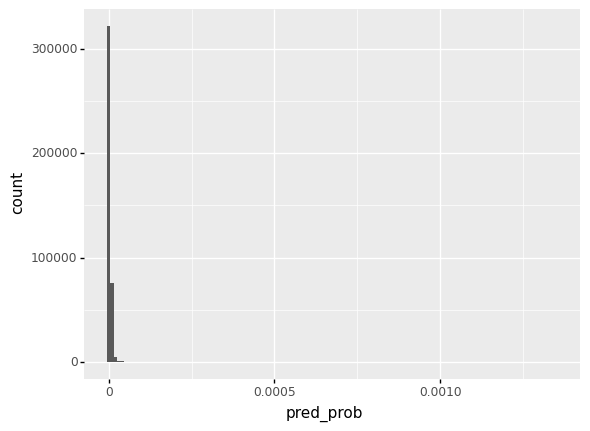

<ggplot: (2995445957531)>

In [23]:
# print(product_df[product_df["label"].isna()].head(12)) # DataFrame Check
# Information Check:
from plotnine import ggplot, aes, geom_histogram
predictions_stage_one = pd.DataFrame({'pred_prob': np.load('../rnn_product/predictions/predictions.npy')})

(ggplot(predictions_stage_one, aes(x='pred_prob')) +
    geom_histogram(binwidth=0.00001))

In [24]:
print(list(np.var(h_df[i]) for i in h_df.columns)) # Check number of informative features
print("Shape:", h_df.shape)
h_df.head(12) # Check DataFrame

[0.10496623, 0.31454465, 11.59943, 0.1323406, 0.13574809, 0.0, 0.11721373, 0.101462856, 0.0, 0.0, 0.036858696, 0.062162157, 0.0, 0.00011021627, 0.31309325, 0.115427695, 0.156387, 0.07402754, 0.041691765, 0.0750214, 0.0, 0.41779098, 0.11325032, 0.0, 0.039088186, 0.06466303, 0.15196888, 0.14233582, 0.20416303, 0.0, 0.0, 0.44582677, 0.20552626, 0.0, 0.25806856, 0.121429294, 0.20915012, 0.11372288, 0.0, 0.20377891, 0.0, 0.0, 0.0, 0.0, 0.14768398, 1.8920592e-09, 0.20552112, 0.115955725, 0.10499232, 0.36611056, 3967634816.5012, 267085330.79507998]
Shape: (404718, 52)


,rnn_product_h0,rnn_product_h1,rnn_product_h2,rnn_product_h3,rnn_product_h4,rnn_product_h5,rnn_product_h6,rnn_product_h7,rnn_product_h8,rnn_product_h9,...,rnn_product_h42,rnn_product_h43,rnn_product_h44,rnn_product_h45,rnn_product_h46,rnn_product_h47,rnn_product_h48,rnn_product_h49,user_id,product_id
0,6.059587,4.311888,14.718194,1.754076,6.152255,0.0,4.499719,5.082187,0.0,0.0,...,0.0,0.0,4.037887,0.0,2.307813,1.820253,4.119867,4.531782,77593,40993
1,6.509175,4.921666,12.789428,1.566942,6.775954,0.0,5.036986,5.694024,0.0,0.0,...,0.0,0.0,4.654946,0.0,2.151116,1.555625,4.754172,4.442995,77593,48742
2,6.048875,4.280264,13.380355,1.943145,6.432046,0.0,4.821102,5.185426,0.0,0.0,...,0.0,0.0,4.127724,0.0,2.260217,1.971612,4.283278,4.561329,77593,0
3,5.726445,3.983845,14.757810,1.949611,6.273759,0.0,4.641682,5.244714,0.0,0.0,...,0.0,0.0,3.942759,0.0,2.467414,1.989205,4.133259,4.635013,0,0
4,5.814314,4.056870,14.776496,1.969618,6.006728,0.0,4.476537,4.791318,0.0,0.0,...,0.0,0.0,3.803838,0.0,2.049008,1.677066,4.005243,4.403607,13910,39921
5,5.985184,4.050377,14.436896,1.978765,6.419369,0.0,4.683187,5.098014,0.0,0.0,...,0.0,0.0,3.955078,0.0,2.231107,1.946187,4.189745,4.780630,13910,0
6,5.352838,3.702462,16.182112,2.162593,5.706567,0.0,4.238505,4.545362,0.0,0.0,...,0.0,0.0,3.551533,0.0,2.321472,1.799906,3.780851,4.510326,71968,23457
7,5.682195,3.889418,14.408702,2.056407,6.345021,0.0,4.601727,4.907295,0.0,0.0,...,0.0,0.0,3.921849,0.0,2.274390,1.788581,4.105195,4.555729,71968,0
8,6.173690,4.834043,14.875593,1.967221,6.323014,0.0,4.892578,5.415617,0.0,0.0,...,0.0,0.0,4.369213,0.0,2.529102,1.992690,4.426844,4.562393,123360,34024
9,6.453001,5.139148,13.188579,1.858461,6.714631,0.0,5.246423,5.858482,0.0,0.0,...,0.0,0.0,4.723725,0.0,2.299855,1.715949,4.954851,4.409637,123360,16953


In [25]:
print(product_df.shape)
product_df.head(12) # Check DataFrame

(379301, 58)


,rnn_product_h0,rnn_product_h1,rnn_product_h2,rnn_product_h3,rnn_product_h4,rnn_product_h5,rnn_product_h6,rnn_product_h7,rnn_product_h8,rnn_product_h9,...,rnn_product_h48,rnn_product_h49,user_id,product_id,label,product_name,aisle_id,department_id,order_id,is_none
0,6.059587,4.311888,14.718194,1.754076,6.152255,0.0,4.499719,5.082187,0.0,0.0,...,4.119867,4.531782,77593,40993,-1.0,Pineapple Soda,77.0,7.0,2578245.0,0.0
1,6.509175,4.921666,12.789428,1.566942,6.775954,0.0,5.036986,5.694024,0.0,0.0,...,4.754172,4.442995,77593,48742,-1.0,Quick 1 Minute Whole Grain Oats,130.0,14.0,2578245.0,0.0
2,6.048875,4.280264,13.380355,1.943145,6.432046,0.0,4.821102,5.185426,0.0,0.0,...,4.283278,4.561329,77593,0,-1.0,NaN,NaN,NaN,2578245.0,1.0
4,5.814314,4.056870,14.776496,1.969618,6.006728,0.0,4.476537,4.791318,0.0,0.0,...,4.005243,4.403607,13910,39921,-1.0,Lemon Lime Soda,77.0,7.0,2143111.0,0.0
5,5.985184,4.050377,14.436896,1.978765,6.419369,0.0,4.683187,5.098014,0.0,0.0,...,4.189745,4.780630,13910,0,-1.0,NaN,NaN,NaN,2143111.0,1.0
6,5.352838,3.702462,16.182112,2.162593,5.706567,0.0,4.238505,4.545362,0.0,0.0,...,3.780851,4.510326,71968,23457,1.0,Zero Calorie Cherry Cola,77.0,7.0,1388050.0,0.0
7,5.682195,3.889418,14.408702,2.056407,6.345021,0.0,4.601727,4.907295,0.0,0.0,...,4.105195,4.555729,71968,0,-1.0,NaN,NaN,NaN,1388050.0,1.0
8,6.173690,4.834043,14.875593,1.967221,6.323014,0.0,4.892578,5.415617,0.0,0.0,...,4.426844,4.562393,123360,34024,-1.0,Classic Soda,77.0,7.0,3371770.0,0.0
9,6.453001,5.139148,13.188579,1.858461,6.714631,0.0,5.246423,5.858482,0.0,0.0,...,4.954851,4.409637,123360,16953,-1.0,Creamy Peanut Butter,88.0,13.0,3371770.0,0.0
10,6.412563,5.061910,13.494882,2.046864,6.689614,0.0,5.224926,5.809087,0.0,0.0,...,4.932617,4.490619,123360,45188,-1.0,Dairy Milk Fine Chocolate Candy Bar,45.0,19.0,3371770.0,0.0


In [26]:
drop_cols = [
    'label',
    'user_id',
    'product_id',
    'order_id',
    'product_name',
    'aisle_id',
    'department_id',
]
user_id = product_df['user_id']
product_id = product_df['product_id']
order_id = product_df['order_id']
label = product_df['label']

product_df.drop(drop_cols, axis=1, inplace=True)
features = product_df.values
feature_names = product_df.columns.values
feature_maxs = features.max(axis=0)
feature_mins = features.min(axis=0)
feature_means = features.mean(axis=0)

In [27]:
# Save features
if not os.path.isdir('data'):
    os.makedirs('data')

np.save('data/user_id.npy', user_id)
np.save('data/product_id.npy', product_id)
np.save('data/order_id.npy', order_id)
np.save('data/features.npy', features)
np.save('data/feature_names.npy', product_df.columns)
np.save('data/feature_maxs.npy', feature_maxs)
np.save('data/feature_mins.npy', feature_mins)
np.save('data/feature_means.npy', feature_means)
np.save('data/label.npy', label)

## NN Blend 

In [8]:
import os

import numpy as np
import tensorflow as tf

import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

from data_frame import DataFrame
from tf_base_model import TFBaseModel
from tf_utils import dense_layer, log_loss


class DataReader(object):

    def __init__(self, data_dir):
        data_cols = [
            'order_id',
            'product_id',
            'features',
            'label'
        ]
        data = [np.load(os.path.join(data_dir, '{}.npy'.format(i)), mmap_mode='r') for i in data_cols]
        df = DataFrame(columns=data_cols, data=data)
        self.data_dim = df['features'].shape[1]

        print(df.shapes())
        print('loaded data')

        # Since we don't have the true label for Kaggle test dataset
        # we generate the test dataset by splitting the training dataset
        ####################
#         df = df.mask(df['label'] != -1)
#         self.train_val_df, self.test_df = df.train_test_split(train_size=0.8)
#         self.train_df, self.val_df = self.train_val_df.train_test_split(train_size=0.9)
        self.test_df = df.mask(df['label'] == -1)
        self.train_df = df.mask(df['label'] != -1)
        self.train_df, self.val_df = self.train_df.train_test_split(train_size=0.9)
        ####################

        print( 'train size', len(self.train_df))
        print( 'val size', len(self.val_df))
        print( 'test size', len(self.test_df))

        self.feature_means = np.load(os.path.join(data_dir, 'feature_means.npy'))
        self.feature_maxs = np.load(os.path.join(data_dir, 'feature_maxs.npy'))
        self.feature_mins = np.load(os.path.join(data_dir, 'feature_mins.npy'))

    def train_batch_generator(self, batch_size):
        return self.batch_generator(
            batch_size=batch_size,
            df=self.train_df,
            shuffle=True,
            num_epochs=10000,
            is_test=False
        )

    def val_batch_generator(self, batch_size):
        return self.batch_generator(
            batch_size=batch_size,
            df=self.val_df,
            shuffle=True,
            num_epochs=10000,
            is_test=False
        )

    def test_batch_generator(self, batch_size):
        return self.batch_generator(
            batch_size=batch_size,
            df=self.test_df,
            shuffle=False,
            num_epochs=1,
            is_test=True
        )

    def batch_generator(self, batch_size, df, shuffle=True, num_epochs=10000, is_test=False):
        batch_gen = df.batch_generator(batch_size, shuffle=shuffle, num_epochs=num_epochs, allow_smaller_final_batch=is_test)
        for batch in batch_gen:
            batch['features'] = np.nan_to_num((batch['features'] - self.feature_means) / (self.feature_maxs - self.feature_mins))
            yield batch

/storage/work/z/zbh5185/myenv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/storage/work/z/zbh5185/myenv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/storage/work/z/zbh5185/myenv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/storage/work/z/zbh5185/myenv/lib64/python3.6/site-pack

In [9]:
class nn(TFBaseModel):

    def __init__(self, hidden_units=500, **kwargs):
        self.hidden_units = hidden_units
        super(nn, self).__init__(**kwargs)

    def calculate_loss(self):
        self.order_id = tf.placeholder(tf.int32, [None])
        self.product_id = tf.placeholder(tf.int32, [None])
        self.features = tf.placeholder(tf.float32, [None, self.reader.data_dim])
        self.label = tf.placeholder(tf.int32, [None])

        h = dense_layer(self.features, self.hidden_units, activation=tf.nn.relu, scope='dense1')
        h = tf.concat([h, self.features], axis=1)
        y_hat = tf.squeeze(dense_layer(h, 1, activation=tf.nn.sigmoid, scope='dense2'), 1)
        loss = log_loss(self.label, y_hat)

        self.prediction_tensors = {
            'order_ids': self.order_id,
            'product_ids': self.product_id,
            'predictions': y_hat,
            'labels': self.label
        }

        return loss

In [10]:
base_dir = './'

dr = DataReader(data_dir=os.path.join(base_dir, 'data'))

# A tiny one for this small dataset
nn = nn(
    reader=dr,
    log_dir=os.path.join(base_dir, 'logs_nn'),
    checkpoint_dir=os.path.join(base_dir, 'checkpoints_nn'),
    prediction_dir=os.path.join(base_dir, 'predictions_nn'),
    optimizer='adam',
    learning_rate=.005,
    hidden_units=64,
    batch_size=128,
    num_training_steps=2000,
    early_stopping_steps=300,
    warm_start_init_step=0,
    regularization_constant=0.0,
    keep_prob=1.0,
    enable_parameter_averaging=False,
    num_restarts=0,
    min_steps_to_checkpoint=100,
    log_interval=20,
    num_validation_batches=2,
)
nn.fit()
nn.restore()
nn.predict()

order_id         (379301,)
product_id       (379301,)
features      (379301, 51)
label            (379301,)
dtype: object
loaded data



new run with parameters:
{'batch_size': 128,
 'checkpoint_dir': './checkpoints_nn',
 'early_stopping_steps': 300,
 'enable_parameter_averaging': False,
 'grad_clip': 5,
 'hidden_units': 64,
 'keep_prob_scalar': 1.0,
 'learning_rate': 0.005,
 'log_dir': './logs_nn',
 'log_interval': 20,
 'loss_averaging_window': 100,
 'min_steps_to_checkpoint': 100,
 'num_restarts': 0,
 'num_training_steps': 2000,
 'num_validation_batches': 2,
 'optimizer': 'adam',
 'prediction_dir': './predictions_nn',
 'reader': <__main__.DataReader object at 0x2b752b7be198>,
 'regularization_constant': 0.0,
 'warm_start_init_step': 0}


train size 114320
val size 12703
test size 252278


all parameters:
[('dense1/weights:0', [51, 64]),
 ('dense1/biases:0', [64]),
 ('dense2/weights:0', [115, 1]),
 ('dense2/biases:0', [1]),
 ('Variable:0', []),
 ('Variable_1:0', []),
 ('beta1_power:0', []),
 ('beta2_power:0', []),
 ('dense1/weights/Adam:0', [51, 64]),
 ('dense1/weights/Adam_1:0', [51, 64]),
 ('dense1/biases/Adam:0', [64]),
 ('dense1/biases/Adam_1:0', [64]),
 ('dense2/weights/Adam:0', [115, 1]),
 ('dense2/weights/Adam_1:0', [115, 1]),
 ('dense2/biases/Adam:0', [1]),
 ('dense2/biases/Adam_1:0', [1])]
trainable parameters:
[('dense1/weights:0', [51, 64]),
 ('dense1/biases:0', [64]),
 ('dense2/weights:0', [115, 1]),
 ('dense2/biases:0', [1])]
trainable parameter count:
3444
/storage/work/z/zbh5185/myenv/lib64/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
[[step        0]]     [[train]]     loss: 0.6960032        [[val]]     loss: 0.69063264       
[[step       20]]     [[train]]     loss: 0.45518322       [[val]]  

built graph


[[step       40]]     [[train]]     loss: 0.39234929       [[val]]     loss: 0.40057873       
[[step       60]]     [[train]]     loss: 0.36262161       [[val]]     loss: 0.37407608       
[[step       80]]     [[train]]     loss: 0.35596816       [[val]]     loss: 0.36113291       
[[step      100]]     [[train]]     loss: 0.3483411        [[val]]     loss: 0.35282243       
[[step      120]]     [[train]]     loss: 0.32424924       [[val]]     loss: 0.32854361       
saving model to ./checkpoints_nn/model
[[step      140]]     [[train]]     loss: 0.32249309       [[val]]     loss: 0.32706538       
saving model to ./checkpoints_nn/model
[[step      160]]     [[train]]     loss: 0.32448913       [[val]]     loss: 0.32478035       
saving model to ./checkpoints_nn/model
[[step      180]]     [[train]]     loss: 0.3159606        [[val]]     loss: 0.32596948       
[[step      200]]     [[train]]     loss: 0.31413133       [[val]]     loss: 0.32361125       
saving model to ./checkpoint

INFO:tensorflow:Restoring parameters from ./checkpoints_nn/model-560
0


saving order_ids with shape (252278,) to ./predictions_nn/order_ids.npy
saving product_ids with shape (252278,) to ./predictions_nn/product_ids.npy


204800


saving predictions with shape (252278,) to ./predictions_nn/predictions.npy
saving labels with shape (252278,) to ./predictions_nn/labels.npy


## GBM Blend

In [28]:
import gc
import os
import pprint as pp
import random

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [29]:
# Data Preprocessing
order_id = np.load('data/order_id.npy')
product_id = np.load('data/product_id.npy')
features = np.load('data/features.npy')
feature_names = np.load('data/feature_names.npy', allow_pickle=True)
label = np.load('data/label.npy')

product_df = pd.DataFrame(data=features, columns=feature_names)
product_df['order_id'] = order_id
product_df['product_id'] = product_id
product_df['label'] = label
del order_id, product_id, features, feature_names, label
gc.collect()

drop_cols = [i for i in product_df.columns if i.startswith('sgns') or i.startswith('nnmf')]
drop_cols += ['order_id', 'product_id', 'label']

In [30]:
# Shuffle Check: after shuffling, the precision keeps unchanged
# label = np.random.permutation(label)
# sum(pd.Series(label).isna())
# Imbalanced Sample Check:

In [31]:
# training
#self.train_val_df, self.test_df = df.train_test_split(train_size=0.8)
#self.train_df, self.val_df = self.train_val_df.train_test_split(train_size=0.9)
# df = product_df[product_df['label'] != -1]
# train_val_df, test_df = train_test_split(df, train_size=0.8)
# train_df, val_df = train_test_split(train_val_df, train_size=0.9)
# del product_df
# gc.collect()
# training
train_df = product_df[product_df['label'] != -1]
test_df = product_df[product_df['label'] == -1]
train_df, val_df = train_test_split(train_df, train_size=.80)
del product_df
gc.collect()

Y_train, Y_val = train_df['label'].astype(int).astype(float), val_df['label'].astype(int).astype(float)
X_train, X_val = train_df.drop(drop_cols, axis=1), val_df.drop(drop_cols, axis=1)
del train_df
gc.collect()

test_orders = test_df['order_id']
test_products = test_df['product_id']
test_labels = test_df['label']
X_test = test_df.drop(drop_cols, axis=1)
del test_df
gc.collect()

0

In [32]:
# Training
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'learning_rate': .01,
    'num_leaves': 32,
    'max_depth': 6,
    'feature_fraction': 0.35,
    'bagging_fraction': 0.5,
    'bagging_freq': 2,
    'early_stopping_round': 1000,
    'scale_pos_weight': 10
}
rounds = 15000
d_train = lgb.Dataset(X_train, label=Y_train, silent=True)
d_valid = lgb.Dataset(X_val, label=Y_val, silent=True)
del X_train, X_val, Y_train, Y_val

valid_sets = [d_train, d_valid]
valid_names = ['train', 'valid']
gbdt = lgb.train(params, d_train, rounds, valid_sets=valid_sets, valid_names=valid_names, verbose_eval=20)

/storage/work/z/zbh5185/myenv/lib64/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
/storage/work/z/zbh5185/myenv/lib64/python3.6/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.


[LightGBM] [Info] Number of positive: 9633, number of negative: 91985
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 101618, number of used features: 35
Training until validation scores don't improve for 1000 rounds
[20]	train's binary_logloss: 0.331196	valid's binary_logloss: 0.338405
[40]	train's binary_logloss: 0.367402	valid's binary_logloss: 0.373988
[60]	train's binary_logloss: 0.405671	valid's binary_logloss: 0.411973
[80]	train's binary_logloss: 0.442405	valid's binary_logloss: 0.448627
[100]	train's binary_logloss: 0.475777	valid's binary_logloss: 0.481987
[120]	train's binary_logloss: 0.505422	valid's binary_logloss: 0.511699
[140]	train's binary_logloss: 0.531382	valid's binary_logloss: 0.537748
[160]	train's binary_logloss: 0.553252	valid's binary_logloss: 0.559847
[1

In [69]:
# Evaluate and Predict
features = gbdt.feature_name()
importance = list(gbdt.feature_importance())
importance = zip(features, importance)
importance = sorted(importance, key=lambda x: x[1])
total = sum(j for i, j in importance)
importance = [(i, float(j)/total) for i, j in importance]
pp.pprint(importance)

test_preds = gbdt.predict(X_test, num_iteration=gbdt.best_iteration)

dirname = 'predictions_gbm'
if not os.path.isdir(dirname):
    os.makedirs(dirname)

np.save(os.path.join(dirname, 'order_ids.npy'), test_orders)
np.save(os.path.join(dirname, 'product_ids.npy'), test_products)
np.save(os.path.join(dirname, 'predictions.npy'), test_preds)
np.save(os.path.join(dirname, 'labels.npy'), test_labels)

[('rnn_product_h3', 0.0),
 ('rnn_product_h5', 0.0),
 ('rnn_product_h6', 0.0),
 ('rnn_product_h8', 0.0),
 ('rnn_product_h9', 0.0),
 ('rnn_product_h12', 0.0),
 ('rnn_product_h13', 0.0),
 ('rnn_product_h14', 0.0),
 ('rnn_product_h15', 0.0),
 ('rnn_product_h17', 0.0),
 ('rnn_product_h19', 0.0),
 ('rnn_product_h20', 0.0),
 ('rnn_product_h22', 0.0),
 ('rnn_product_h23', 0.0),
 ('rnn_product_h24', 0.0),
 ('rnn_product_h26', 0.0),
 ('rnn_product_h27', 0.0),
 ('rnn_product_h29', 0.0),
 ('rnn_product_h30', 0.0),
 ('rnn_product_h31', 0.0),
 ('rnn_product_h32', 0.0),
 ('rnn_product_h33', 0.0),
 ('rnn_product_h35', 0.0),
 ('rnn_product_h36', 0.0),
 ('rnn_product_h38', 0.0),
 ('rnn_product_h39', 0.0),
 ('rnn_product_h40', 0.0),
 ('rnn_product_h41', 0.0),
 ('rnn_product_h42', 0.0),
 ('rnn_product_h43', 0.0),
 ('rnn_product_h45', 0.0),
 ('rnn_product_h46', 0.0),
 ('is_none', 0.0),
 ('rnn_product_h7', 0.016129032258064516),
 ('rnn_product_h11', 0.016129032258064516),
 ('rnn_product_h25', 0.016129032258

## Logistic Blend

In [71]:
import gc
import os
import pprint as pp

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [72]:
# Data Preprocessing
order_id = np.load('data/order_id.npy')
product_id = np.load('data/product_id.npy')
features = np.load('data/features.npy')
feature_names = np.load('data/feature_names.npy', allow_pickle=True)
label = np.load('data/label.npy')

# Dictionary to obtain aisle and department information
products = pd.read_csv('../../data/raw/products.csv')
product_to_aisle = dict(zip(products['product_id'], products['aisle_id']))
product_to_department = dict(zip(products['product_id'], products['department_id']))
product_to_name = dict(zip(products['product_id'], products['product_name']))

product_df = pd.DataFrame(data=features, columns=feature_names)
product_df['order_id'] = order_id
product_df['product_id'] = product_id
product_df['label'] = label

In [73]:
product_df[product_df["label"]!=-1].head(6) # Check the dataframe

,rnn_product_h0,rnn_product_h1,rnn_product_h2,rnn_product_h3,rnn_product_h4,rnn_product_h5,rnn_product_h6,rnn_product_h7,rnn_product_h8,rnn_product_h9,...,rnn_product_h44,rnn_product_h45,rnn_product_h46,rnn_product_h47,rnn_product_h48,rnn_product_h49,is_none,order_id,product_id,label
5,5.352838,3.702462,16.182112,2.162593,5.706567,0.0,4.238505,4.545362,0.0,0.0,...,3.551533,0.0,2.321472,1.799906,3.780851,4.510326,0.0,1388050.0,23457,1.0
20,6.030151,4.730082,13.988225,2.076976,6.675218,0.0,5.042298,5.244120,0.0,0.0,...,4.440458,0.0,2.349509,1.997754,4.594883,4.831266,0.0,3116355.0,38689,0.0
21,6.284298,5.014303,12.174001,2.019396,6.609884,0.0,5.236545,5.415007,0.0,0.0,...,4.595059,0.0,1.926563,1.644131,4.816975,4.420271,0.0,3116355.0,32578,0.0
22,5.996841,4.775189,13.616653,2.197349,6.396957,0.0,5.080297,5.233307,0.0,0.0,...,4.406622,0.0,2.141155,1.862389,4.651524,4.642500,0.0,3116355.0,19906,0.0
23,6.330435,5.101635,11.834969,1.930874,6.795727,0.0,5.341567,5.598269,0.0,0.0,...,4.712720,0.0,1.957665,1.576969,5.030081,4.376763,0.0,3116355.0,42342,0.0
24,6.181380,5.008355,12.644301,2.055216,6.725125,0.0,5.272603,5.528182,0.0,0.0,...,4.557807,0.0,2.094815,1.783030,4.953433,4.526399,0.0,3116355.0,35628,0.0


aisle_counts: [34012, 31454, 16618, 13136, 9646, 7112, 6941, 6837, 5608, 5310, 5259, 5232, 5154, 4666, 4413, 4247, 4155, 4111, 3862, 3857, 3821, 3806, 3739, 3443, 3384, 3321, 3258, 3120, 3117, 3094, 3090, 3088, 3081, 3079, 3003, 2982, 2765, 2715, 2566, 2515, 2440, 2396, 2365, 2304, 2218, 2146, 2072, 2018, 2003, 1943, 1910, 1727, 1712, 1701, 1595, 1520, 1437, 1300, 1260, 1256, 1229, 1203, 1156, 1148, 1141, 1136, 1089, 1067, 1029, 932, 908, 906, 905, 898, 897, 875, 817, 801, 779, 762, 762, 756, 709, 671, 660, 598, 556, 495, 484, 454, 443, 418, 415, 389, 378, 378, 377, 375, 358, 333, 326, 325, 325, 320, 320, 301, 279, 271, 255, 245, 238, 234, 233, 227, 214, 213, 210, 198, 194, 174, 168, 156, 149, 132, 129, 128, 126, 120, 113, 112, 112, 102, 95, 57]
department_counts: [88477, 48770, 28963, 24046, 22975, 22604, 11892, 10912, 9945, 9679, 8407, 7327, 7104, 5485, 4615, 3312, 1417, 876, 801, 443, 378]


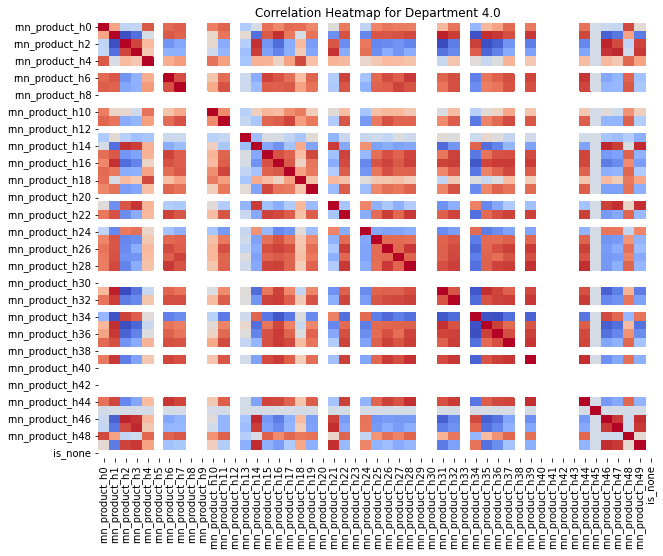

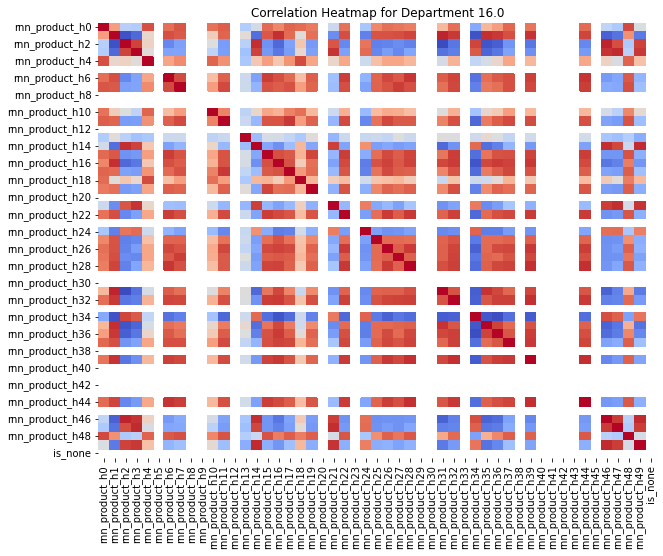

In [74]:
### EDA: heterogeneity across aisles and departments
import seaborn as sns
import matplotlib.pyplot as plt

# Map aisle and department information to the product_df
product_df['aisle_id'] = product_df['product_id'].map(product_to_aisle)
product_df['department_id'] = product_df['product_id'].map(product_to_department)

# Count the number of samples in each aisle and department
aisle_counts = product_df['aisle_id'].value_counts().tolist()
department_counts = product_df['department_id'].value_counts().tolist()

print("aisle_counts:", aisle_counts)
print("department_counts:", department_counts)

# Assign department_id to each product in the dataframe
product_df = product_df.assign(department_id=product_df['product_id'].map(product_to_department))

# Identify the top 2 departments
most_common_departments = product_df['department_id'].value_counts().nlargest(2).index.tolist()

# Initialize a dictionary to store the correlation matrices
corr_matrices = {}

# Calculate the correlation matrix for each of the top 2 departments
for department in most_common_departments:
    department_df = product_df[product_df['department_id'] == department]
    department_df = department_df.drop(columns=['order_id', 'product_id', 'label', 'aisle_id', 'department_id'])
    corr_matrix = department_df.corr()
    corr_matrices[department] = corr_matrix

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', cbar=False)
    plt.title(f'Correlation Heatmap for Department {department}')
    plt.show()

# Print the correlation matrices
# for department, corr_matrix in corr_matrices.items():
#    print(f'Correlation Matrix for Department {department}:\n{corr_matrix}\n')


In [75]:
del order_id, product_id, features, feature_names, label
gc.collect()

drop_cols = [i for i in product_df.columns if i.startswith('sgns') or i.startswith('nnmf')]
drop_cols += ['order_id', 'product_id', 'label', 'aisle_id', 'department_id']

# training

#self.train_val_df, self.test_df = df.train_test_split(train_size=0.8)
#self.train_df, self.val_df = self.train_val_df.train_test_split(train_size=0.9)
df = product_df[product_df['label'] != -1]
df = df.dropna()
train_val_df, test_df = train_test_split(df, train_size=0.8)
train_df, val_df = train_test_split(train_val_df, train_size=0.9)
del product_df
gc.collect()

Y_train, Y_val = train_df['label'].astype(int).astype(float), val_df['label'].astype(int).astype(float)
X_train, X_val = train_df.drop(drop_cols, axis=1), val_df.drop(drop_cols, axis=1)
del train_df
gc.collect()

test_orders = test_df['order_id']
test_products = test_df['product_id']
test_labels = test_df['label']
X_test = test_df.drop(drop_cols, axis=1)
del test_df
gc.collect()

0

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

def tune_regularization(X_train, Y_train, X_val, Y_val, C_values):
    """
    Function to tune the regularization parameter of a logistic regression model.
    
    Parameters:
    X_train: Training data features
    Y_train: Training data labels
    X_val: Validation data features
    Y_val: Validation data labels
    C_values: List of regularization parameters to try
    
    Returns:
    best_C: The regularization parameter that resulted in the lowest log loss on the validation set
    best_log_loss: The best log loss achieved on the validation set
    """
    # Initialize variables to store the best log loss and corresponding regularization parameter
    best_log_loss = float('inf')
    best_C = None

    # Iterate over the regularization parameters
    for C in C_values:
        # Initialize and train the Logistic Regression model
        log_reg = LogisticRegression(penalty='l2', C=C, solver='liblinear')
        log_reg.fit(X_train, Y_train)

        # Predict the probabilities of the validation set
        val_preds = log_reg.predict_proba(X_val)[:, 1]

        # Calculate the log loss on the validation set
        val_log_loss = log_loss(Y_val, val_preds)
        print(f'Regularization Parameter: {C}, Validation Log Loss: {val_log_loss}')

        # If this log loss is smaller than the current best, update the best log loss and regularization parameter
        if val_log_loss < best_log_loss:
            best_log_loss = val_log_loss
            best_C = C

    return best_C, best_log_loss

# Define a list of regularization parameters to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Call the function
best_C, best_log_loss = tune_regularization(X_train, Y_train, X_val, Y_val, C_values)
print(f'Best Regularization Parameter: {best_C}, Best Validation Log Loss: {best_log_loss}')


Regularization Parameter: 0.001, Validation Log Loss: 0.31629419794069086
Regularization Parameter: 0.01, Validation Log Loss: 0.31375237559417213
Regularization Parameter: 0.1, Validation Log Loss: 0.3119882014841488
Regularization Parameter: 1, Validation Log Loss: 0.3114608831915409
Regularization Parameter: 10, Validation Log Loss: 0.31143981443175806
Regularization Parameter: 100, Validation Log Loss: 0.3115004408993566
Best Regularization Parameter: 10, Best Validation Log Loss: 0.31143981443175806


In [77]:
### Department-specific Models
# Get the top 2 departments
top_departments = df['department_id'].value_counts().index[:2]

# Run the function on the top 2 departments
log_reg_coef_list = []  # Create a list to store the coefficients
for department in top_departments:
    # Filter the data for the current department
    department_data = df[df['department_id'] == department]
    
    # Split the data into features and target variable
    X = department_data.drop('label', axis=1)
    y = department_data['label']
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Run the function
    best_C, best_log_loss = tune_regularization(X_train, y_train, X_val, y_val, C_values)
    
    # Train a Logistic Regression model with the best regularization parameter
    log_reg = LogisticRegression(penalty='l2', C=best_C, solver='liblinear')
    log_reg.fit(X_train, y_train)
    
    log_reg_coef_list.append(log_reg.coef_.flatten())  # Append the coefficients to the list
    
    # Print the coefficients
    print(f'Department: {department}, Coefficients: {log_reg.coef_}')


Regularization Parameter: 0.001, Validation Log Loss: 0.40332522482974853
Regularization Parameter: 0.01, Validation Log Loss: 0.4033252248319621
Regularization Parameter: 0.1, Validation Log Loss: 0.4033252248321834
Regularization Parameter: 1, Validation Log Loss: 0.4033252248322056
Regularization Parameter: 10, Validation Log Loss: 0.40332522483220784
Regularization Parameter: 100, Validation Log Loss: 0.40332522483220795
Department: 4.0, Coefficients: [[-1.39530113e-08 -1.21652485e-08 -1.75239625e-08 -3.26900231e-09
  -1.40077287e-08  0.00000000e+00 -1.19004771e-08 -1.26691047e-08
   0.00000000e+00  0.00000000e+00 -6.66940022e-09 -1.18546019e-08
   0.00000000e+00 -4.55173724e-12 -4.87768426e-09 -9.16615105e-09
  -9.89387415e-09 -1.01016925e-08 -8.17563781e-09 -6.54835736e-09
   0.00000000e+00 -7.61079274e-09 -1.05539796e-08  0.00000000e+00
  -4.37500299e-10 -4.15618773e-09 -1.21815092e-08 -1.13347837e-08
  -1.24075421e-08  0.00000000e+00  0.00000000e+00 -8.42080237e-09
  -1.2316889

In [49]:
# log_reg_coef_list = np.array(log_reg_coef_list).reshape(2,-1)

In [50]:
# log_reg_coef_list

array([[ 0.00000000e+00, -4.40627422e-13,  0.00000000e+00,
        -9.70143613e-09, -9.68870916e-09, -4.62082302e-09,
        -1.00568950e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.27415319e-09,  0.00000000e+00,
         0.00000000e+00, -6.41492814e-09, -1.08587645e-08,
         0.00000000e+00, -8.92679174e-09, -9.96252023e-09,
         0.00000000e+00,  0.00000000e+00, -1.04007453e-08,
         0.00000000e+00,  1.28051920e-12, -2.86737594e-09,
        -9.61567309e-10, -9.92662994e-09, -7.52683755e-10,
         0.00000000e+00, -1.04372626e-08, -1.08324976e-08,
         0.00000000e+00,  0.00000000e+00, -8.62416723e-09,
         0.00000000e+00, -2.47184132e-09, -1.01656273e-08,
        -1.88524625e-08, -1.13501058e-08,  0.00000000e+00,
        -1.14503379e-08, -9.83114747e-09,  0.00000000e+00,
        -1.18281016e-08, -3.68523400e-09, -7.53598451e-09,
         0.00000000e+00,  0.00000000e+00, -3.74667906e-11,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

## HTL-Logistic Blend

## F-score Evaluation

In [52]:
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd

In [53]:
# Load Data
gbm_df = pd.DataFrame({
    'order_id': np.load('predictions_gbm/order_ids.npy'),
    'product_id': np.load('predictions_gbm/product_ids.npy'),
    'prediction_gbm': np.load('predictions_gbm/predictions.npy'),
    'label': np.load('predictions_gbm/labels.npy')
})

nn_df = pd.DataFrame({
    'order_id': np.load('predictions_nn/order_ids.npy'),
    'product_id': np.load('predictions_nn/product_ids.npy'),
    'prediction_nn': np.load('predictions_nn/predictions.npy'),
})

In [54]:
# Combine the prediction
# pred_df = gbm_df.merge(nn_df, how='left', on=['order_id', 'product_id'])
# pred_df['prediction'] = .9*pred_df['prediction_gbm'] + .1*pred_df['prediction_nn']

In [55]:
# Calculate F-score
def cal_f_value(pred, label, model):
    TP = sum((label==1) & (pred==1))
    FP = sum((pred==1) & (label==0))
    FN = sum((pred==0) & (label==1))
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F_value = 2 / (1/recall + 1/precision)
    summary = [model, recall, precision, F_value]
    summary_name = ["model", "recall", "precision", "F_value"]
    return(pd.DataFrame(dict(zip(summary_name, summary)), index=[0]))

true_label = gbm_df['label']
# gbm
pred_gbm = (gbm_df['prediction_gbm'] > 0.5).astype(int)
print(cal_f_value(pred_gbm, true_label, "GBM"))
# nn
pred_nn = (nn_df['prediction_nn'] > 0.5).astype(int)
print(cal_f_value(pred_nn, true_label, "NN"))

ZeroDivisionError: division by zero

In [78]:
pred_gbm.unique
# pred_nn.unique # All Zeros

<bound method Series.unique of 0         0
1         0
2         0
3         0
4         0
         ..
252273    0
252274    0
252275    0
252276    0
252277    0
Name: prediction_gbm, Length: 252278, dtype: int64>